## 例3.2 & 3.3

In [306]:
class KDNode:
    def __init__(self,split_dim,split_value,data,left=None,right=None):
        # 孩子节点
        self.left = left
        self.right = right
        # 在切分超平面上的点
        self.data = data
        # 切分值
        self.split_value = split_value
        # 切分维度
        self.split_dim = split_dim

In [311]:
class KDTree:
    def __init__(self,X):
        X = np.array(X)
        self.data_dim = np.shape(X)[1]
        self.root = self._split(X,0)
    def _split(self,X,split_dim):
        # 子区域没有实例，停止切分
        if len(X)==0:
            return None
        # 计算X在split_dim上的中位数，作为切分点
        """
        书中对切分点的描述：
        （1）P41：“选择训练实例点在选定坐标轴上的中位数为切分点”
         (2)P41注释2：“中位数：一组数据按大小排列起来，处在中间未知的一个数或最中间两个数的平均值”。
        由于第一个切分点的选择不同，导致本例结果与书中不同：
        具体地，在本例第一次选择切分点时，对于$[2,4,5,7,8,9]$，按照书中介绍应选择中位数6作为切分点，不过本例依照书中结果，选择7作为切分点;
        """
        # median_value = np.median(X[:,split_dim])
        median_value = X[np.argsort(X[:,split_dim])[len(X)//2]][split_dim]
        # 以split_dim为坐标轴，根据切分点，划分数据
        X_left = X[X[:,split_dim]<median_value]
        X_right = X[X[:,split_dim]>median_value]
        # 递归的构造左右子节点
        next_split_dim = (split_dim+1)%self.data_dim
        left_child =  self._split(X_left,next_split_dim)
        right_child =  self._split(X_right,next_split_dim)
        # 位于当前切分超平面的点
        data = X[X[:,split_dim]==median_value]
        # 构造并返回节点
        node = KDNode(split_dim,median_value,data,left_child,right_child)
        return node
    
    def _search(self,root,traget_x,topk,cur_result):
        # 定义一个namedtuple类型result，并包含topk_data，topk_distance属性。
        from collections import namedtuple
        Return_tuple = namedtuple('return_tuple', ['topk_data', 'topk_distance','max_distance'])
        # --------------------------
        # 递归的向下访问
        # --------------------------
        # 当前要查询节点为空，则返回结果
        if root is None:
            return cur_result
        # 移动到孩子节点
        split_dim,split_value = root.split_dim,root.split_value
        if traget_x[split_dim]<split_value:
            next_node,backtrack_node = root.left,root.right
        else:
            next_node,backtrack_node = root.right,root.left
        #递归访问
        cur_result = self._search(next_node,traget_x,topk,cur_result)
        if cur_result is None:
            topk_data, topk_distance,max_distance = [],[],float('inf')
        else:
            topk_data, topk_distance,max_distance =  cur_result.topk_data, cur_result.topk_distance,cur_result.max_distance 
        # --------------------------
        # 向上回退
        # --------------------------
        #3-a:计算（当前结点对应的切分超平面上的实例点，目标点）间的距离，更新topk结果
        for cur_data in root.data:
            cur_dst = np.linalg.norm(cur_data-traget_x,2)
            if len(topk_data)>=topk and cur_dst>max_distance:continue
            #更新topK结果
            if len(topk_data)<topk:
                topk_distance.append(cur_dst)
                topk_data.append(cur_data)
            else:
                idx = topk_distance.index(max_distance)
                topk_data[idx],topk_distance[idx] = cur_data,cur_dst
            max_distance = max(topk_distance)
        cur_result = Return_tuple(topk_data, topk_distance,max_distance)
        # 3-b:判断 超球体（目标点，当前最近点）是否与超矩形区域相交
        tmp_distance=np.abs(traget_x[split_dim]-split_value)#目标点到超矩形区域的距离
        if tmp_distance<max_distance:
            # 搜索邻域
            cur_result = self._search(backtrack_node,traget_x,topk,cur_result)
        return cur_result
    
    def query(self,x,topk):
        result_tuple = self._search(self.root,x,topk,None)
        topk_data, topk_distance =  result_tuple.topk_data, result_tuple.topk_distance 
        return topk_data,topk_distance



In [318]:
# 数据
import numpy as np
data = [[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]]
data=np.array(data)
# 建KD树
model = KDTree(data)
# 找topK
query = [3,4.5]
topk_data,topk_distance = model.query(query,topk=2)

<ipython-input-319-102424513180>:12: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(data[:,0],data[:,1],color='', marker='o', edgecolors='b')


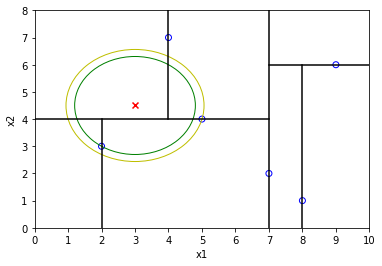

In [319]:
#绘制数据点
from matplotlib import pyplot as plt 
plt.xlabel('x1')
plt.ylabel('x2')
x_lim,y_lim = max(data[:,0])+1,max(data[:,1])+1
# 
plt.xlim(0,x_lim)
plt.ylim(0,y_lim)
# 
plt.xticks(range(x_lim+1))
plt.yticks(range(y_lim+1))
plt.scatter(data[:,0],data[:,1],color='', marker='o', edgecolors='b')
# 绘制切分超平面
from collections import deque
nodes_q = deque([[model.root,0,[0,x_lim],[0,y_lim]]])#[node,dim,[x_min,x_max],[y_min,y_max]]
while len(nodes_q):
    n,dim,[x_min,x_max],[y_min,y_max] = nodes_q.popleft()
    if n is None:
        continue
    if dim==0:
        # 
        nodes_q.append([n.left,1,[x_min,n.split_value],[y_min,y_max]])
        nodes_q.append([n.right,1,[n.split_value,x_max],[y_min,y_max]])
        # 
        x = np.ones(int(y_max-y_min+1))*n.split_value
        y = np.arange(y_min,y_max+1)
    elif dim==1:
        nodes_q.append([n.left,0,[x_min,x_max],[y_min,n.split_value]])
        nodes_q.append([n.right,0,[x_min,x_max],[n.split_value,y_max]])
        # 
        x = np.arange(x_min,x_max+1)
        y = np.ones(int(x_max-x_min+1))*n.split_value
    else:
        pass
    plt.plot(x,y,'black')
#
plt.scatter(query[0],query[1],color='r', marker='x')
# 
colors=['g','y']
for idx,dst in enumerate(topk_distance):
    circle = plt.Circle((query[0],query[1]), dst, color=colors[idx], fill=False)
    plt.gcf().gca().add_artist(circle)
# 
plt.show()